### Compositional analysis of the DMD Fibroblasts scRNA-Seq dataset using `milopy`
- **Developed by**: Christian Eger
- **Modified by**: Carlos Talavera-López
- **Talavera-López Lab - Würzburg Institute for Systems Immunology - Faculty of Medicine - Julius Maximilian Universität Würzburg**
- **Created on**: 231207
- **Last modified**: 240227

## Import statements and environment prep

In [1]:
import scvi
import rpy2
import numpy as np
import scanpy as sc
import pandas as pd
import pertpy as pt
import seaborn as sns
import matplotlib.pyplot as plt
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


### Set up working environment

In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.10.7
scanpy      1.10.1
-----
PIL                 10.3.0
absl                NA
adjustText          1.1.1
appnope             0.1.4
arrow               1.3.0
arviz               0.18.0
asttokens           NA
attr                23.2.0
blitzgsea           NA
certifi             2024.02.02
cffi                1.16.0
chardet             5.2.0
charset_normalizer  3.3.2
chex                0.1.86
comm                0.2.2
contextlib2         NA
custom_inherit      2.4.1
cycler              0.12.1
cython_runtime      NA
dateutil            2.9.0.post0
debugpy             1.8.1
decorator           5.1.1
decoupler           1.6.0
docrep              0.3.2
etils               1.7.0
exceptiongroup      1.2.1
executing           2.0.1
flax                0.8.4
fsspec              2024.5.0
h5py                3.11.0
idna                3.7
igraph              0.11.5
importlib_resources NA
ipykernel           6.29.4
ipywidgets          8.1.3
jax                 0.4.28
jaxlib    

In [3]:
rpy2.robjects.numpy2ri.activate()

## Data preparation

### Data loading

In [4]:
adata = sc.read_h5ad("../../data/heart_mm_nuclei-23-0092_FB_states_ctl240131.raw.h5ad")
adata.obs['cell_types'] = adata.obs['C_scANVI'].copy()
adata

AnnData object with n_obs × n_vars = 9377 × 32285
    obs: 'cell_source', 'cell_type', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'cell_states', 'seed_labels', 'genotype', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'cell_types'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap'

In [5]:
adata
adata.obs

,cell_source,cell_type,donor,n_counts,n_genes,percent_mito,percent_ribo,region,sample,scrublet_score,...,pct_counts_ribo,percent_mt2,percent_chrY,XIST-counts,S_score,G2M_score,_scvi_batch,_scvi_labels,C_scANVI,cell_types
TCGCAGGAGGCTTCCG-1-A9_2,HIRI-Nuclei,NaN,A9_2,21704.167582,4100,NaN,NaN,NaN,A9_2,NaN,...,2.181208,0.051699,0.052433,0.0,0.138445,-0.249553,0,5,FB6,FB6
CCGTTCACAAATTGCC-1-A9_2,HIRI-Nuclei,NaN,A9_2,20085.235445,3727,NaN,NaN,NaN,A9_2,NaN,...,0.511073,0.017888,0.158189,0.0,2.531231,4.013015,0,3,FB4,FB4
CCAAGCGGTTTCGTAG-1-A9_2,HIRI-Nuclei,NaN,A9_2,17265.164129,3080,NaN,NaN,NaN,A9_2,NaN,...,3.985056,0.050505,0.083022,0.0,-0.197844,-0.295802,0,5,FB6,FB6
AACGGGACACTCAAGT-1-A9_2,HIRI-Nuclei,NaN,A9_2,18226.763651,3271,NaN,NaN,NaN,A9_2,NaN,...,1.737660,0.025373,0.107643,0.0,0.319994,0.019119,0,5,FB6,FB6
GGAATGGAGACAACAT-1-A9_2,HIRI-Nuclei,NaN,A9_2,16886.781580,2987,NaN,NaN,NaN,A9_2,NaN,...,2.150709,0.059742,0.111518,0.0,0.042216,-0.392916,0,5,FB6,FB6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCTGAATGTTCCAAAC-1-B2_2,HIRI-Nuclei,NaN,B2_2,4475.382305,601,NaN,NaN,NaN,B2_2,NaN,...,2.523364,0.113084,0.000000,0.0,-0.102554,-0.133337,5,6,FB1,FB1
GAGATGGTCAGCAATC-1-B2_2,HIRI-Nuclei,NaN,B2_2,4649.491983,624,NaN,NaN,NaN,B2_2,NaN,...,3.594470,0.157604,0.000000,0.0,0.054592,-0.019439,5,6,FB2,FB2
TATTGGGGTAAGTTAG-1-B2_2,HIRI-Nuclei,NaN,B2_2,4805.336013,651,NaN,NaN,NaN,B2_2,NaN,...,3.053435,0.130725,0.286260,0.0,-0.016692,-0.084612,5,6,FB3,FB3
TGCAGTACATATTCGG-1-B2_2,HIRI-Nuclei,NaN,B2_2,5047.229118,689,NaN,NaN,NaN,B2_2,NaN,...,2.173913,0.120983,0.000000,0.0,0.254759,-0.167414,5,6,FB4,FB4


In [6]:
sc.pp.neighbors(adata, n_neighbors=150, use_rep="X_scANVI")

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:19)


In [7]:
milo = pt.tl.Milo()
mdata = milo.load(adata)
mdata

MuData object with n_obs × n_vars = 9377 × 32285
  2 modalities
    rna:	9377 x 32285
      obs:	'cell_source', 'cell_type', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'cell_states', 'seed_labels', 'genotype', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'cell_types'
      var:	'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
      uns:	'neighbors'
      obsm:	'X_scANVI', 'X_scVI', 'X_umap'
      obsp:	'distances', 'connectivities'
    milo:	0 x 0

In [8]:
milo.make_nhoods(mdata, prop=0.1)

/Users/cartalop/miniforge3/envs/milopy/lib/python3.10/site-packages/pertpy/tools/_milo.py:186: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.2420304 3.5198088 3.200109  3.2398703 3.2422445 3.17241   3.0951927
 3.8212    2.7218776 3.3687005 4.0629106 2.8853743 2.6187992 3.0854573
 3.3470888 3.6380491 3.1692173 3.9368234 3.7405775 3.9611118 3.1607995
 5.451503  3.997859  3.5597456 4.1193085 3.6936142 5.3377533 3.1209626
 3.6470778 2.7776017 2.4590385 2.655545  3.649071  2.724304  2.7780144
 2.45465   4.0311666 2.7746658 3.1916118 2.859147  2.3791265 2.903585
 3.57486   2.975133  3.17188   3.8193216 3.9683185 3.6231375 4.922239
 5.3505454 3.2518218 5.4434094 6.0271816 3.767871  3.3788366 2.701441
 3.4523568 3.2509117 4.2073965 3.3639674 2.8818784 2.4011729 3.7632153
 2.771304  3.3194501 4.22749   2.62422   2.4665942 2.9779959 3.2001414
 2.9873545 5.4613376 2.5265076 3.3469334 3.4971428 2.6231978 3.291209

## Defining of Neighbourhoods

In [9]:
adata.obsm["nhoods"]

<9377x721 sparse matrix of type '<class 'numpy.float32'>'
	with 182051 stored elements in Compressed Sparse Row format>

Text(0, 0.5, '# neighbouthoods')

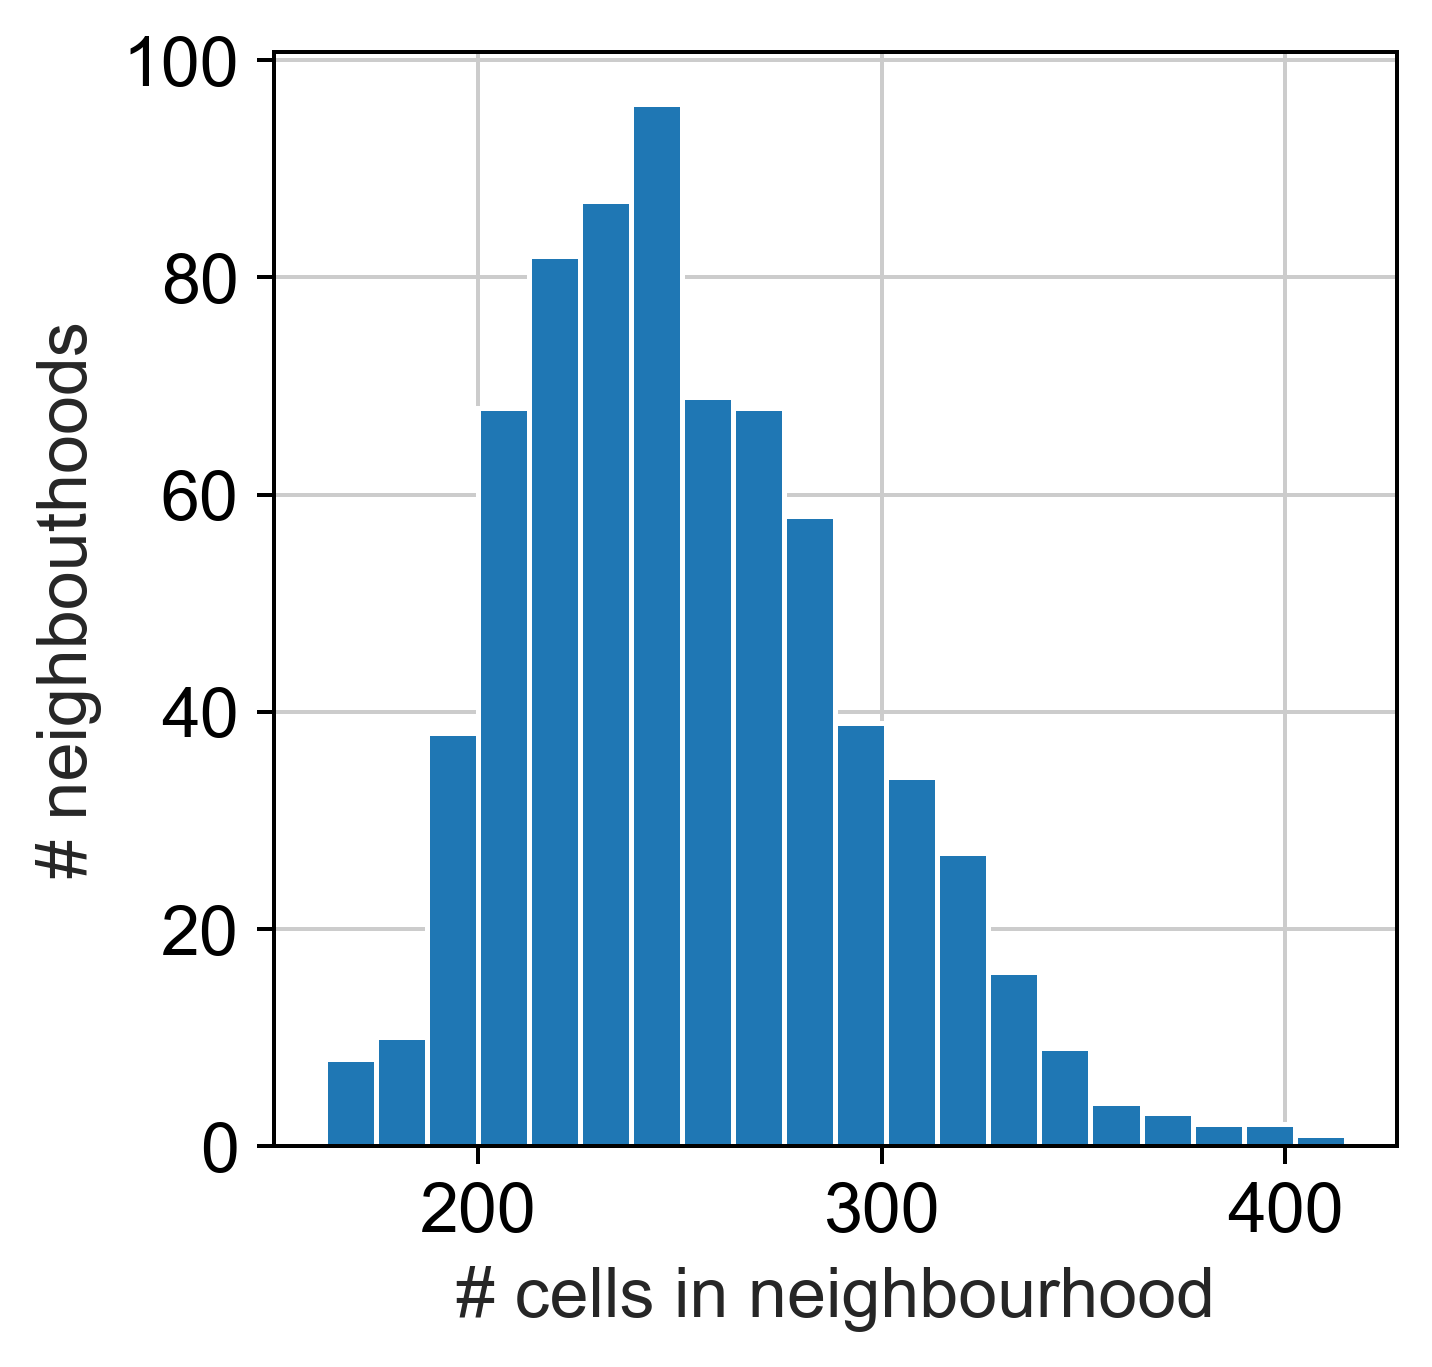

In [10]:
nhood_size = adata.obsm["nhoods"].toarray().sum(0)
plt.hist(nhood_size, bins=20)
plt.xlabel("# cells in neighbourhood")
plt.ylabel("# neighbouthoods")

In [11]:
np.median(nhood_size)

247.0

In [12]:
sc.pp.neighbors(adata, n_neighbors=150, use_rep="X_scANVI", key_added="milo")
milo.make_nhoods(mdata, neighbors_key="milo", prop=0.1)

computing neighbors
    finished: added to `.uns['milo']`
    `.obsp['milo_distances']`, distances for each pair of neighbors
    `.obsp['milo_connectivities']`, weighted adjacency matrix (0:00:07)


/Users/cartalop/miniforge3/envs/milopy/lib/python3.10/site-packages/pertpy/tools/_milo.py:186: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.2420304 3.5198088 3.200109  3.2398703 3.2422445 3.17241   3.0951927
 3.8212    2.7218776 3.3687005 4.0629106 2.8853743 2.6187992 3.0854573
 3.3470888 3.6380491 3.1692173 3.9368234 3.7405775 3.9611118 3.1607995
 5.451503  3.997859  3.5597456 4.1193085 3.6936142 5.3377533 3.1209626
 3.6470778 2.7776017 2.4590385 2.655545  3.649071  2.724304  2.7780144
 2.45465   4.0311666 2.7746658 3.1916118 2.859147  2.3791265 2.903585
 3.57486   2.975133  3.17188   3.8193216 3.9683185 3.6231375 4.922239
 5.3505454 3.2518218 5.4434094 6.0271816 3.767871  3.3788366 2.701441
 3.4523568 3.2509117 4.2073965 3.3639674 2.8818784 2.4011729 3.7632153
 2.771304  3.3194501 4.22749   2.62422   2.4665942 2.9779959 3.2001414
 2.9873545 5.4613376 2.5265076 3.3469334 3.4971428 2.6231978 3.291209

Text(0, 0.5, '# neighbouthoods')

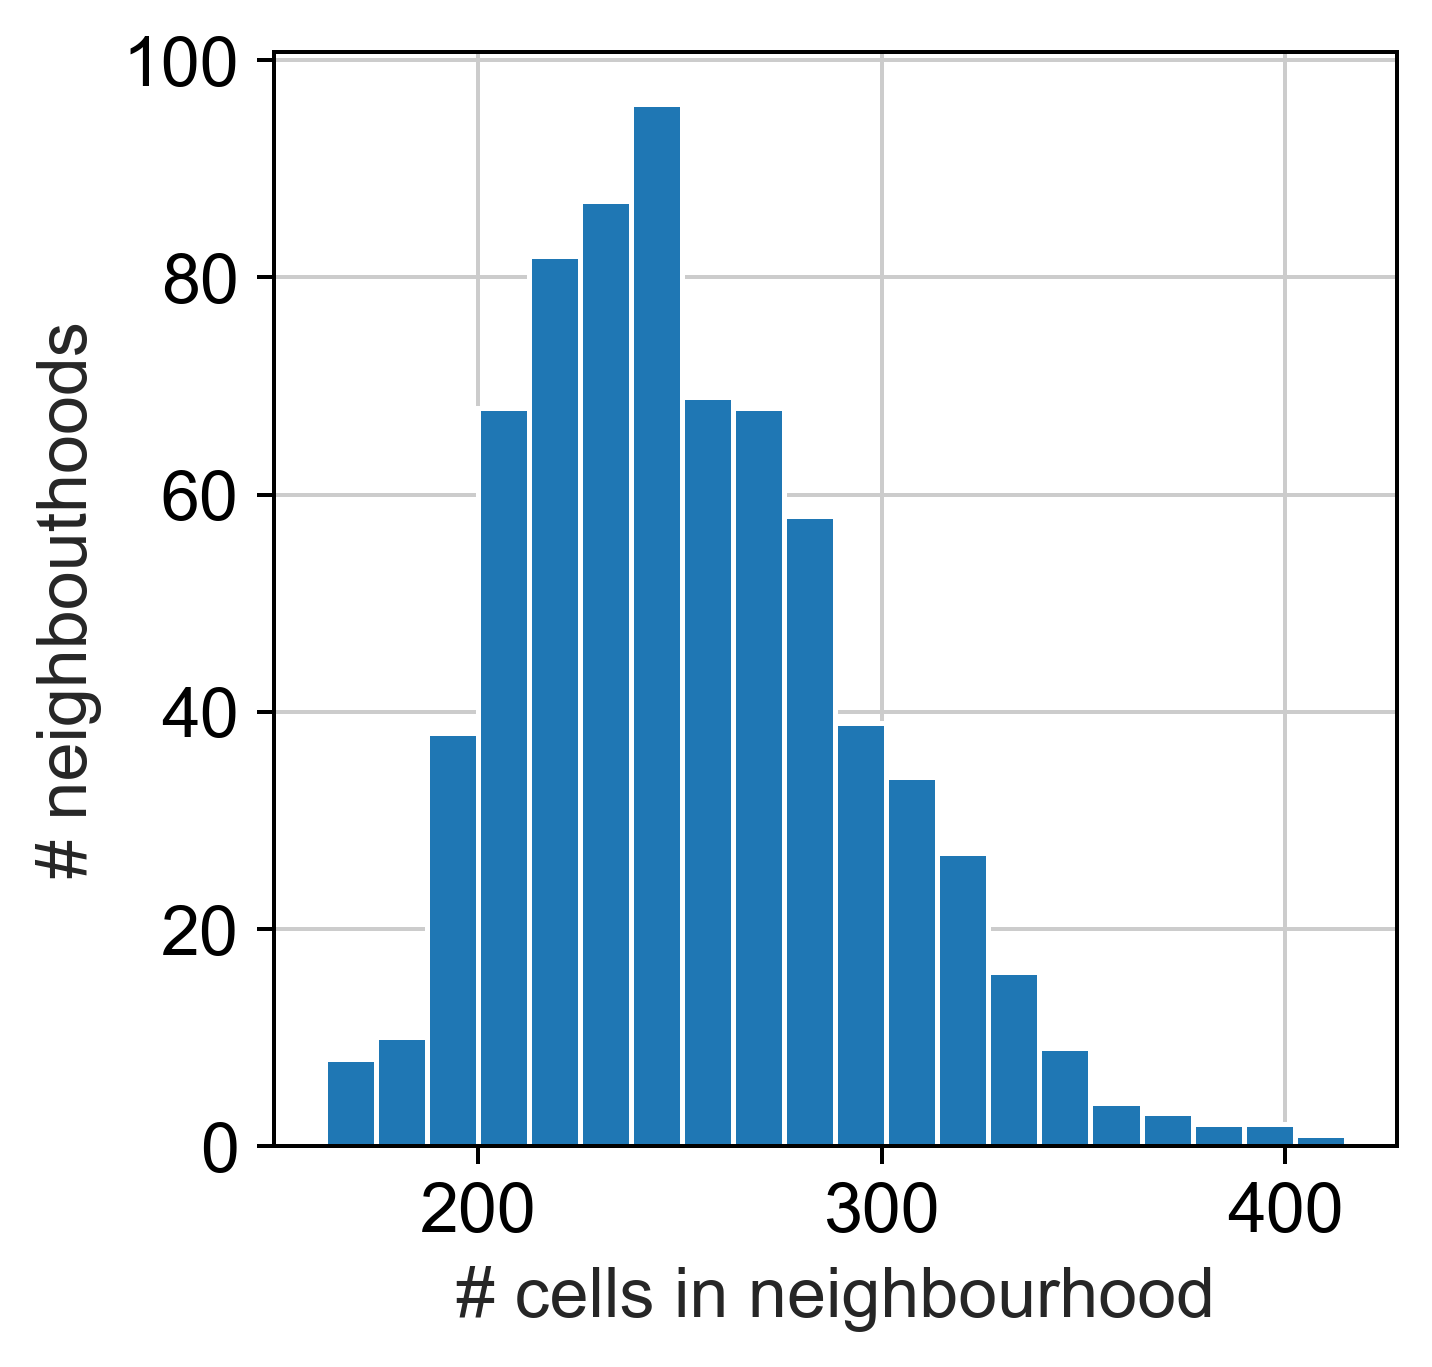

In [13]:
nhood_size = adata.obsm["nhoods"].toarray().sum(0)
plt.hist(nhood_size, bins=20)
plt.xlabel("# cells in neighbourhood")
plt.ylabel("# neighbouthoods")

In [14]:
np.median(nhood_size)

247.0

In [15]:
milo.count_nhoods(mdata, sample_col="sample")

/Users/cartalop/miniforge3/envs/milopy/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


MuData object with n_obs × n_vars = 9377 × 32285
  2 modalities
    rna:	9377 x 32285
      obs:	'cell_source', 'cell_type', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'cell_states', 'seed_labels', 'genotype', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'cell_types', 'nhood_ixs_random', 'nhood_ixs_refined', 'nhood_kth_distance'
      var:	'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
      uns:	'neighbors', 'nhood_neighbors_key', 'milo'
      obsm:	'X_scANVI', 'X_scVI', 'X_umap', 'nhoods'
      obsp:	'distances', 'connectivities', 'milo_distances', 'milo_connectivities'
    milo:	6 x 721
      var:	'index_cell', 'kth_distance'
      uns:	'sample_col'

Text(0, 0.5, 'Mean # cells per sample in nhood')

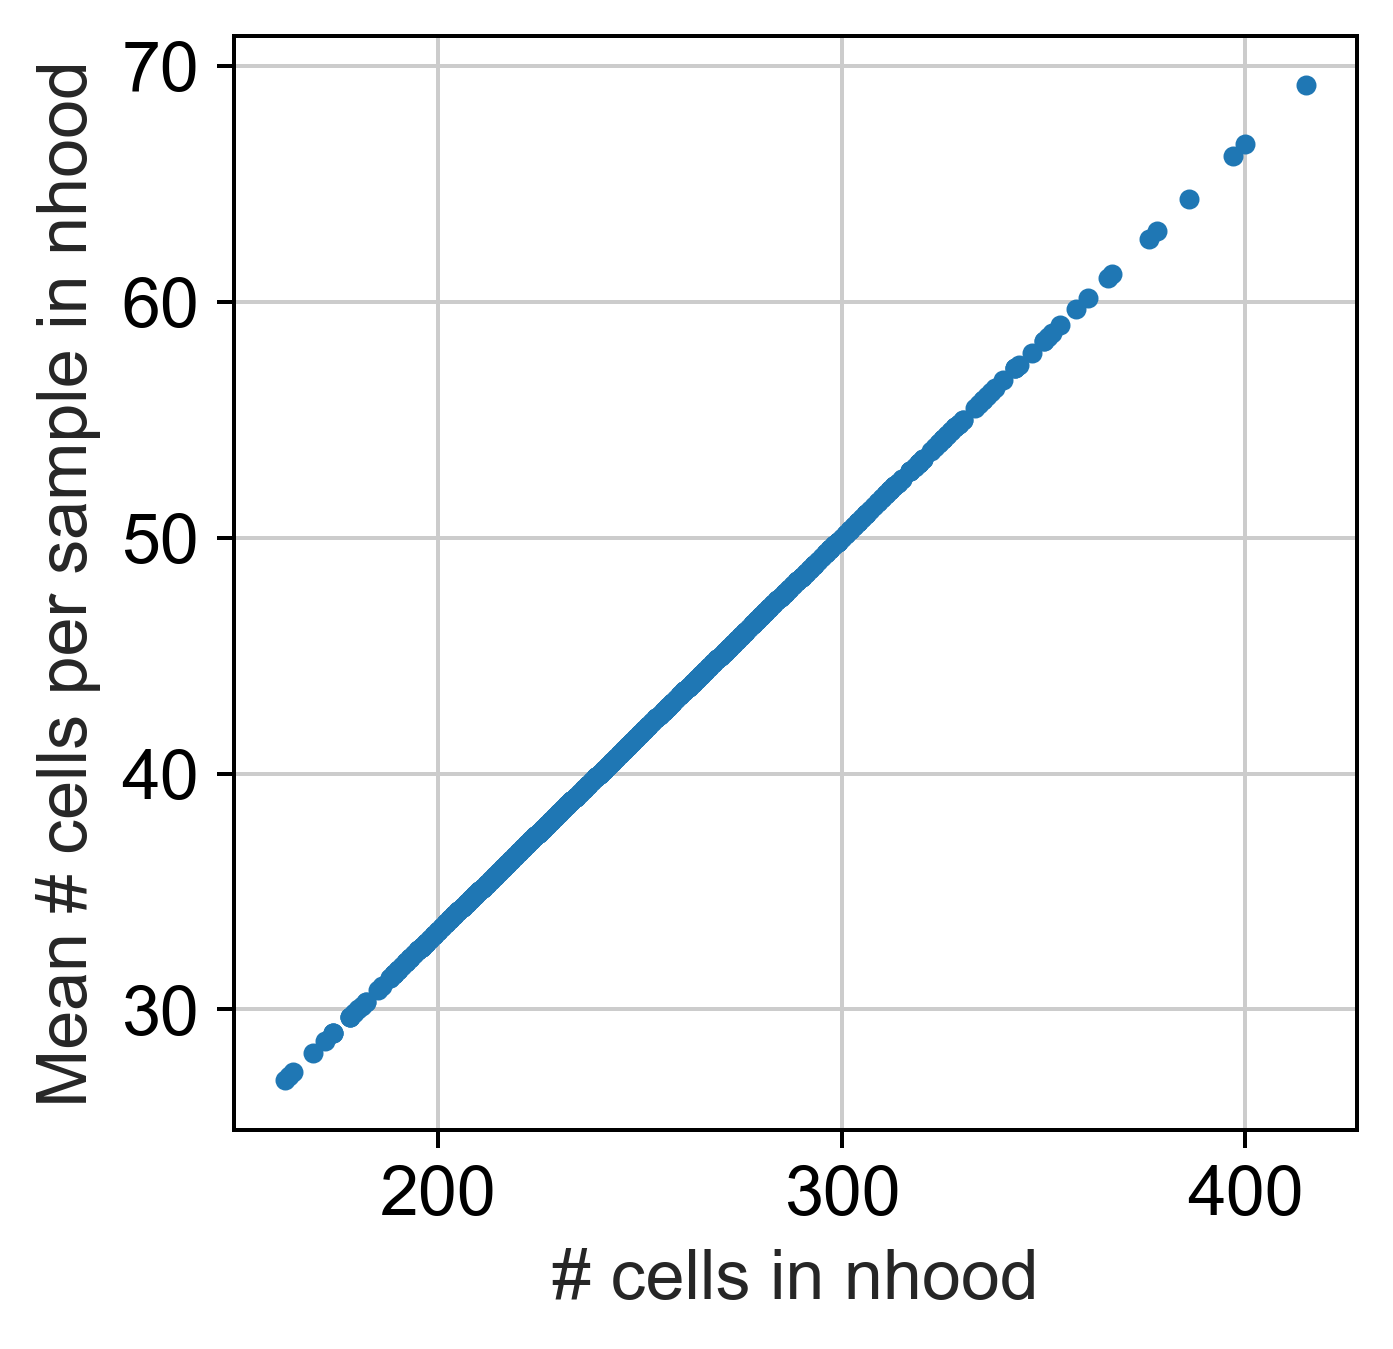

In [16]:
mean_n_cells = mdata["milo"].X.toarray().mean(0)
plt.plot(nhood_size, mean_n_cells, ".")
plt.xlabel("# cells in nhood")
plt.ylabel("Mean # cells per sample in nhood")

In [17]:
mdata["rna"].obs["genotype"].cat.categories

Index(['Mdx', 'MdxSCID', 'WT'], dtype='object')

In [18]:
milo.da_nhoods(
    mdata, design="~genotype", model_contrasts="genotypeWT-genotypeMdx"
)
#milo_results_healthy_iav = mdata["milo"].obs.copy()
#milo_results_healthy_iav

/Users/cartalop/miniforge3/envs/milopy/lib/python3.10/site-packages/pertpy/tools/_milo.py:691: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pvalues = pvalues[keep_nhoods][o]
/Users/cartalop/miniforge3/envs/milopy/lib/python3.10/site-packages/pertpy/tools/_milo.py:692: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  w = w[keep_nhoods][o]


## Data Diagnostics

KeyError: 'logFC.1'

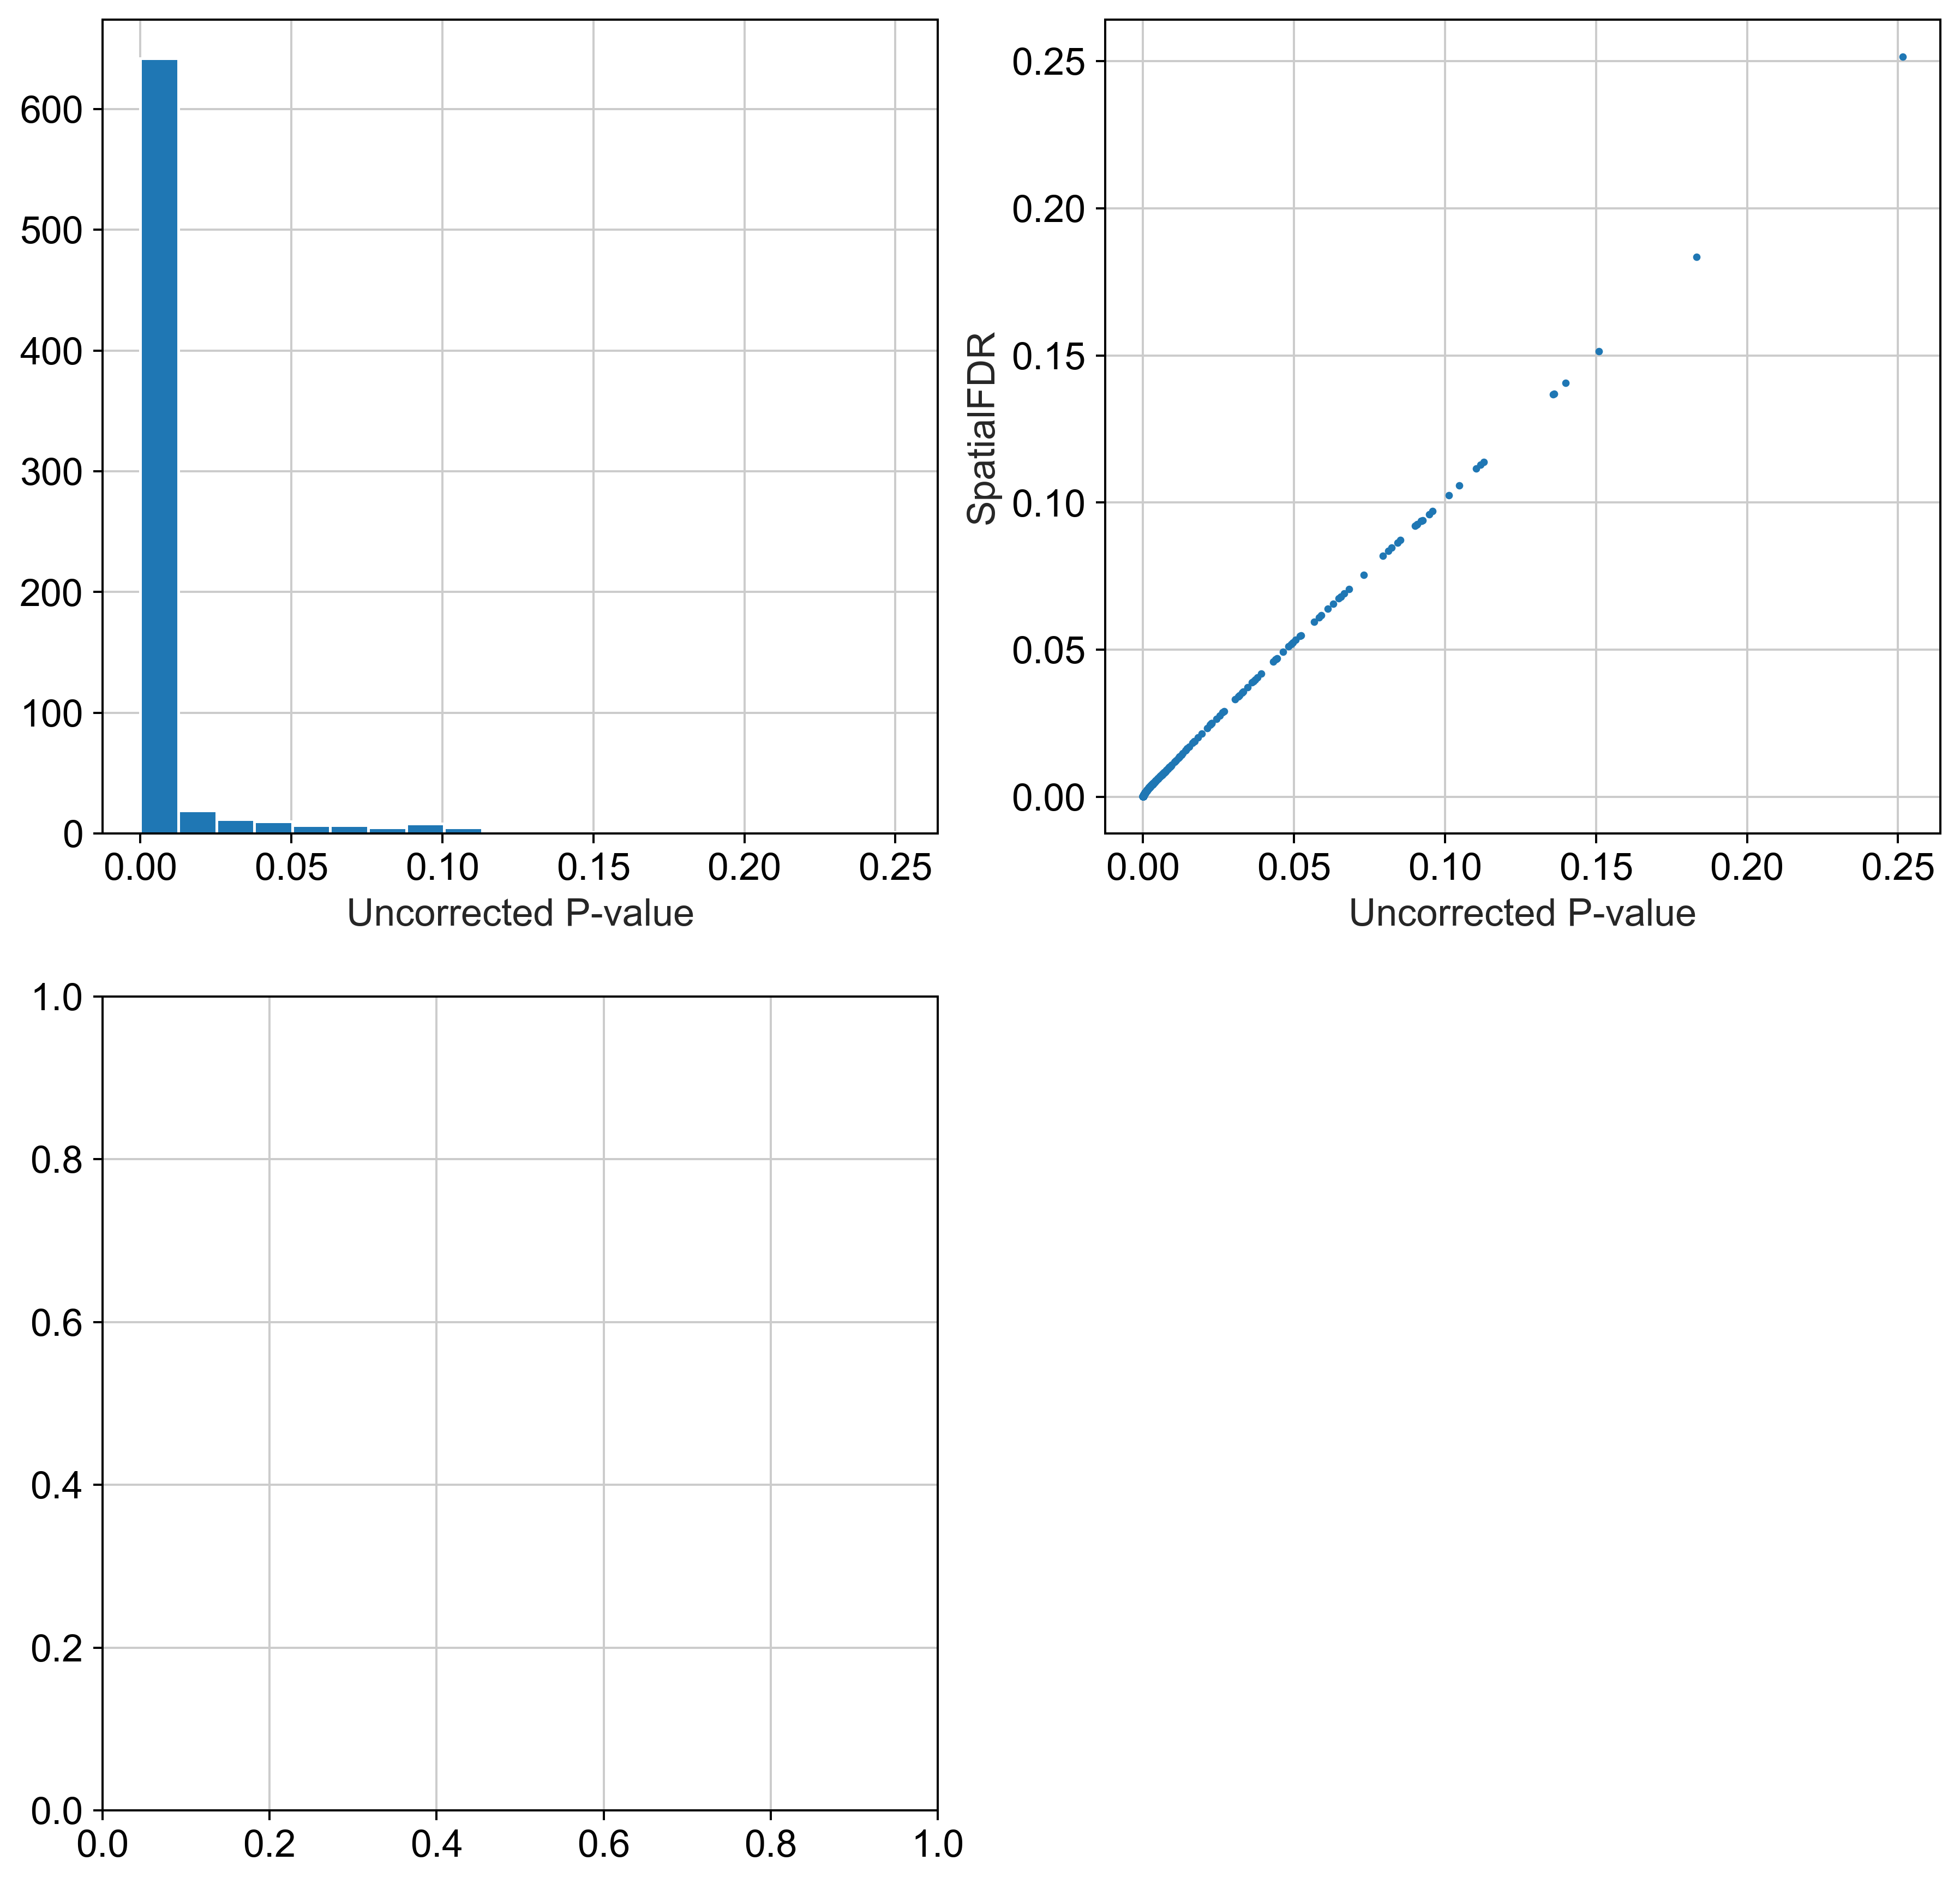

In [19]:
def plot_milo_diagnostics(mdata):
    alpha = 0.1  ## significance threshold

    with plt.rc_context({"figure.figsize": [12, 12]}):

        ## Check P-value histogram
        plt.subplot(2, 2, 1)
        plt.hist(mdata["milo"].var["PValue"], bins=20)
        plt.xlabel("Uncorrected P-value")

        ## Visualize extent of multiple-testing correction
        plt.subplot(2, 2, 2)
        plt.scatter(
            mdata["milo"].var["PValue"],
            mdata["milo"].var["SpatialFDR"],
            s=3,
        )
        plt.xlabel("Uncorrected P-value")
        plt.ylabel("SpatialFDR")

        ## Visualize volcano plot
        plt.subplot(2, 2, 3)
        plt.scatter(
            mdata["milo"].var["logFC.1"],
            -np.log10(mdata["milo"].var["SpatialFDR"]),
            s=3,
        )
        plt.axhline(
            y=-np.log10(alpha),
            color="red",
            linewidth=1,
            label=f"{int(alpha*100)} % SpatialFDR",
        )
        plt.legend()
        plt.xlabel("log-Fold Change")
        plt.ylabel("- log10(SpatialFDR)")
        plt.tight_layout()

        ## Visualize MA plot
        df = mdata["milo"].var
        emp_null = df[df["SpatialFDR"] >= alpha]["logFC.1"].mean()
        df["Sig"] = df["SpatialFDR"] < alpha

        plt.subplot(2, 2, 4)
        sns.scatterplot(data=df, x="logCPM", y="logFC.1", hue="Sig")
        plt.axhline(y=0, color="grey", linewidth=1)
        plt.axhline(y=emp_null, color="purple", linewidth=1)
        plt.legend(title=f"< {int(alpha*100)} % SpatialFDR")
        plt.xlabel("Mean log-counts")
        plt.ylabel("log-Fold Change")
        plt.show()


plot_milo_diagnostics(mdata)

## Plotting of log fold change in cell compartments

In [ ]:
mdata

In [ ]:
milo.build_nhood_graph(mdata)

In [ ]:
mdata_milo = mdata.copy()
mdata_milo

In [ ]:
sc.settings.set_figure_params(dpi=200)
milo.build_nhood_graph(mdata)
with plt.rc_context({"figure.figsize": [4, 4]}):
    milo.plot_nhood_graph(mdata, alpha=0.1, min_size=0.3, plot_edges=False)
    sc.pl.umap(mdata["rna"], color=["C_scANVI", "genotype"], ncols= 2, legend_loc="right margin", legend_fontsize=8 , frameon= False, size = 5)

In [ ]:
from pertpy.tools import Milo

milo = Milo()

with plt.rc_context({"figure.figsize": [4, 4]}):
    milo.plot_nhood_graph(mdata, alpha=0.1, min_size=0.4, plot_edges=False)
    sc.pl.umap(mdata["rna"], color="C_scANVI", legend_loc="on data", frameon=False, size=2)

In [ ]:

# Define as mixed if fraction of cells in nhood with same label is lower than 0.75
milo.annotate_nhoods(mdata, anno_col="C_scANVI")
#mdata["milo"].var = mdata["milo"].var.cat.add_categories(['Mixed'])
#mdata["milo"].var.loc[mdata["milo"].var["nhood_annotation_frac"] < 0.75, "nhood_annotation"] = "Mixed"

In [ ]:
fig, axs = plt.subplots(2, 3, sharey=False, sharex=False, tight_layout=True, figsize=(12, 6))

# Plot FB1 histogram
axs[0, 0].hist(mdata["milo"].var[mdata["milo"].var["nhood_annotation"].isin(["FB1"])]["logFC"], bins=20, color="steelblue")
axs[0, 0].axvline(x=0, color='r', linewidth=1, linestyle='--')
axs[0, 0].set_title("FB1")

# Plot FB2 histogram
axs[0, 1].hist(mdata["milo"].var[mdata["milo"].var["nhood_annotation"].isin(["FB2"])]["logFC"], bins=20, color="darkorange")
axs[0, 1].axvline(x=0, color='r', linewidth=1, linestyle='--')
axs[0, 1].set_title("FB2")

# Plot FB3 histogram
axs[0, 2].hist(mdata["milo"].var[mdata["milo"].var["nhood_annotation"].isin(["FB3"])]["logFC"], bins=20, color="forestgreen")
axs[0, 2].axvline(x=0, color='r', linewidth=1, linestyle='--')
axs[0, 2].set_title("FB3")

# Plot FB4 histogram
axs[1, 0].hist(mdata["milo"].var[mdata["milo"].var["nhood_annotation"].isin(["FB4"])]["logFC"], bins=20, color="purple")
axs[1, 0].axvline(x=0, color='r', linewidth=1, linestyle='--')
axs[1, 0].set_title("FB4")

# Plot FB5 histogram
axs[1, 1].hist(mdata["milo"].var[mdata["milo"].var["nhood_annotation"].isin(["FB5"])]["logFC"], bins=20, color="magenta")
axs[1, 1].axvline(x=0, color='r', linewidth=1, linestyle='--')
axs[1, 1].set_title("FB5")

# Plot FB6 histogram
axs[1, 2].hist(mdata["milo"].var[mdata["milo"].var["nhood_annotation"].isin(["FB6"])]["logFC"], bins=20, color="teal")
axs[1, 2].axvline(x=0, color='r', linewidth=1, linestyle='--')
axs[1, 2].set_title("FB6")

plt.tight_layout()

In [ ]:
def significance_ratios(mdata_object):
    d = {"cell_compartments": [], "significance_ratio": []}
    for i in mdata_object["milo"].var["nhood_annotation"].unique():
        significant = 0
        insignificant = 0
        d["cell_compartments"].append(i)
        for j in mdata_object["milo"].var[mdata_object["milo"].var["nhood_annotation"].isin([i])]["Sig"]:
            if j == True:
                significant += 1
            else:
                insignificant += 1
        d["significance_ratio"].append(significant/(significant+insignificant))
    df = pd.DataFrame.from_dict(data=d)
    return df

In [ ]:
mdata['rna'].obs.head()

In [ ]:
significance = significance_ratios(mdata)
significance

In [ ]:
order = ["FB1", "FB2", "FB3", "FB4", "FB5", "FB6"]
fig, axs = plt.subplots(2, figsize=(10,10), gridspec_kw={'height_ratios': [3, 1]})
sns.boxplot(data=mdata["milo"].var, x="nhood_annotation", y="logFC", order=order, ax=axs[0])
axs[0].axhline(y=0, color='r', linewidth=1, linestyle='--')
sns.barplot(data=significance, x="cell_compartments", y="significance_ratio", order=order, ax=axs[1])
plt.ylim(0, 1)
axs[1].axhline(y=0.8, color='r', linewidth=1, linestyle='--')

In [ ]:
plt.figure(figsize=(10, 10))
sns.boxplot(data=mdata["milo"].var, x="nhood_annotation", y="logFC")

In [ ]:
mdata["rna"]